<a href="https://colab.research.google.com/github/MinhTNF6906/Spotify-Song-Pred/blob/main/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install itables

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import itables
from itables import show
import re
from datetime import datetime
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import torchvision.models as models
from torchvision.utils import make_grid
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

import warnings
warnings.filterwarnings('ignore')

Interactive table to view the data

In [ ]:
dataset = pd.read_csv("sample_data/SpotifyFeatures.csv", on_bad_lines='skip')
show(dataset)

Loading ITables v2.5.2 from the internet... (need help?)


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232725 entries, 0 to 232724
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   genre             232725 non-null  object 
 1   artist_name       232725 non-null  object 
 2   track_name        232724 non-null  object 
 3   track_id          232725 non-null  object 
 4   popularity        232725 non-null  int64  
 5   acousticness      232725 non-null  float64
 6   danceability      232725 non-null  float64
 7   duration_ms       232725 non-null  int64  
 8   energy            232725 non-null  float64
 9   instrumentalness  232725 non-null  float64
 10  key               232725 non-null  object 
 11  liveness          232725 non-null  float64
 12  loudness          232725 non-null  float64
 13  mode              232725 non-null  object 
 14  speechiness       232725 non-null  float64
 15  tempo             232725 non-null  float64
 16  time_signature    23

In [ ]:
dataset.describe()

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
count,232725.000000,232725.000000,232725.000000,2.327250e+05,232725.000000,232725.000000,232725.000000,232725.000000,232725.000000,232725.000000,232725.000000
mean,41.127502,0.368560,0.554364,2.351223e+05,0.570958,0.148301,0.215009,-9.569885,0.120765,117.666585,0.454917
std,18.189948,0.354768,0.185608,1.189359e+05,0.263456,0.302768,0.198273,5.998204,0.185518,30.898907,0.260065
min,0.000000,0.000000,0.056900,1.538700e+04,0.000020,0.000000,0.009670,-52.457000,0.022200,30.379000,0.000000
25%,29.000000,0.037600,0.435000,1.828570e+05,0.385000,0.000000,0.097400,-11.771000,0.036700,92.959000,0.237000
50%,43.000000,0.232000,0.571000,2.204270e+05,0.605000,0.000044,0.128000,-7.762000,0.050100,115.778000,0.444000
75%,55.000000,0.722000,0.692000,2.657680e+05,0.787000,0.035800,0.264000,-5.501000,0.105000,139.054000,0.660000
max,100.000000,0.996000,0.989000,5.552917e+06,0.999000,0.999000,1.000000,3.744000,0.967000,242.903000,1.000000


In [ ]:
dataset = dataset[['popularity', 'danceability', 'valence', 'energy']]

In [ ]:
print("Before:", dataset.shape)
dataset = dataset.drop_duplicates()
print("After:", dataset.shape)

Before: (232725, 4)
After: (190955, 4)


In [ ]:
dataset = dataset[dataset['popularity'] != 0]
print("Before:", dataset.shape)
dataset = dataset[dataset['popularity'] != 0]
print("After:", dataset.shape)

Before: (184775, 4)
After: (184775, 4)


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 184775 entries, 1 to 232724
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   popularity    184775 non-null  int64  
 1   danceability  184775 non-null  float64
 2   valence       184775 non-null  float64
 3   energy        184775 non-null  float64
dtypes: float64(3), int64(1)
memory usage: 7.0 MB


In [ ]:
dataset.describe()

,popularity,danceability,valence,energy
count,184775.000000,184775.000000,184775.000000,184775.000000
mean,38.864873,0.540767,0.450028,0.571492
std,16.457104,0.187655,0.264171,0.272316
min,1.000000,0.056900,0.000000,0.000020
25%,28.000000,0.418000,0.226000,0.372000
50%,39.000000,0.557000,0.438000,0.611000
75%,51.000000,0.680000,0.660000,0.799000
max,100.000000,0.989000,1.000000,0.999000


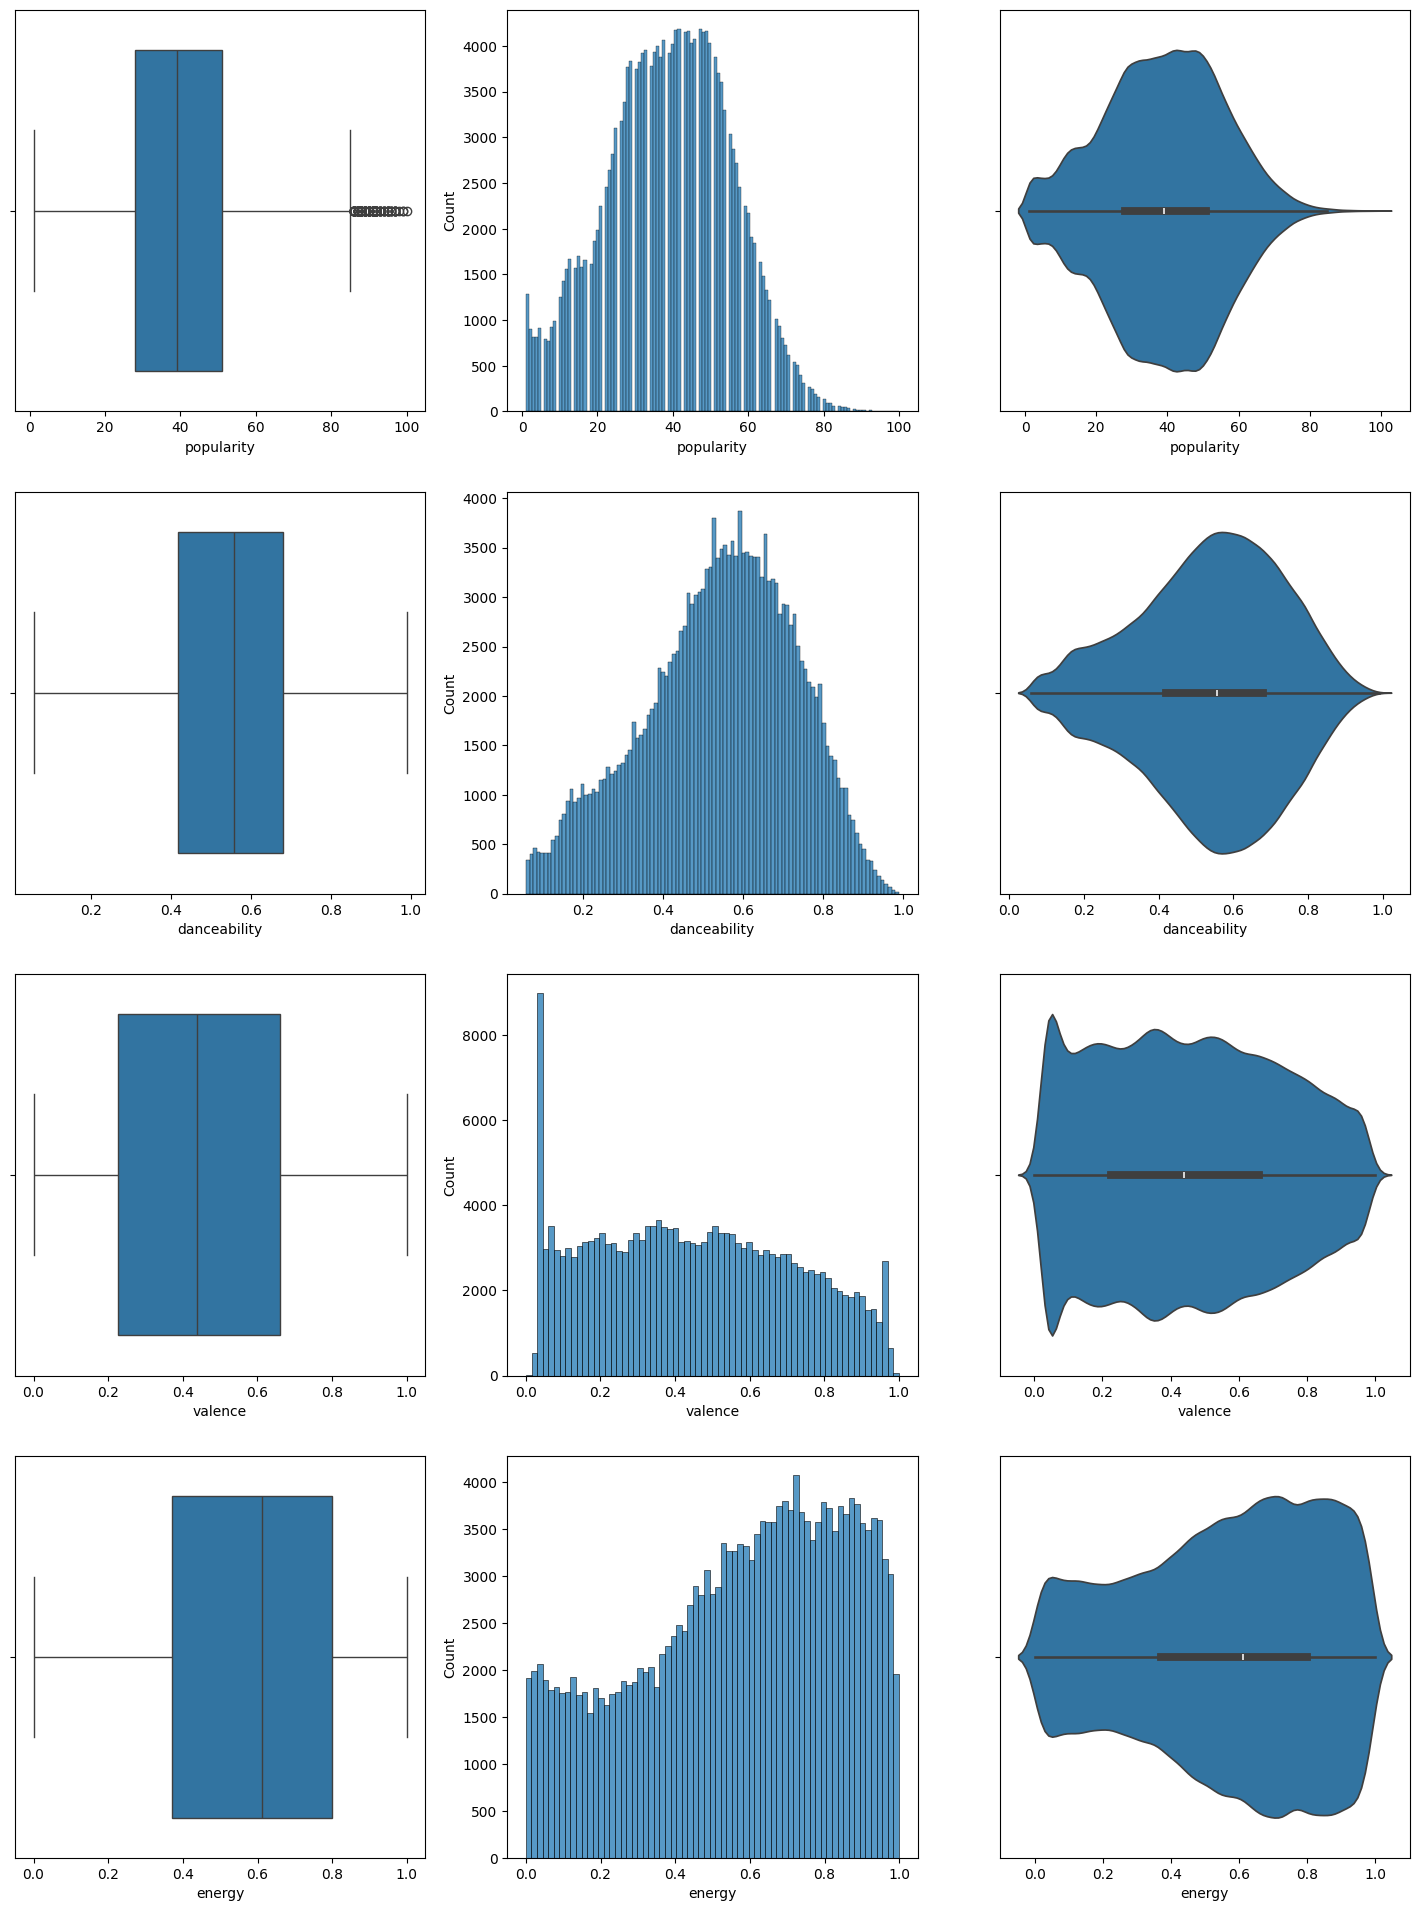

In [ ]:
f, axes = plt.subplots(4, 3, figsize=(18, 24))

count = 0
for var in dataset:
    sb.boxplot(data = dataset[var], orient = "h", ax = axes[count,0])
    sb.histplot(data = dataset[var], ax = axes[count,1])
    sb.violinplot(data = dataset[var], orient = "h", ax = axes[count,2])
    count += 1

In [ ]:
dataset.corr()

,popularity,danceability,valence,energy
popularity,1.000000,0.253331,0.087580,0.218171
danceability,0.253331,1.000000,0.575632,0.352749
valence,0.087580,0.575632,1.000000,0.453327
energy,0.218171,0.352749,0.453327,1.000000


<Axes: >

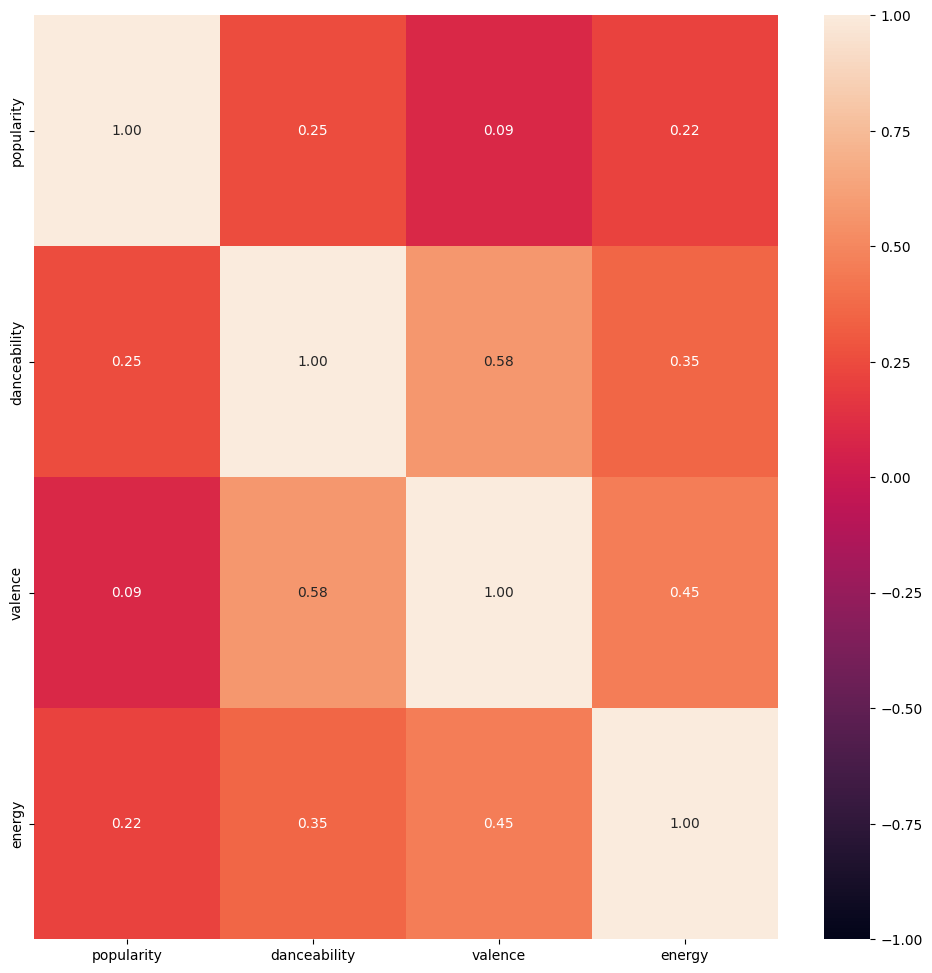

In [ ]:
f = plt.figure(figsize=(12, 12))
sb.heatmap(dataset.corr(), vmin = -1, vmax = 1, annot = True, fmt = ".2f")

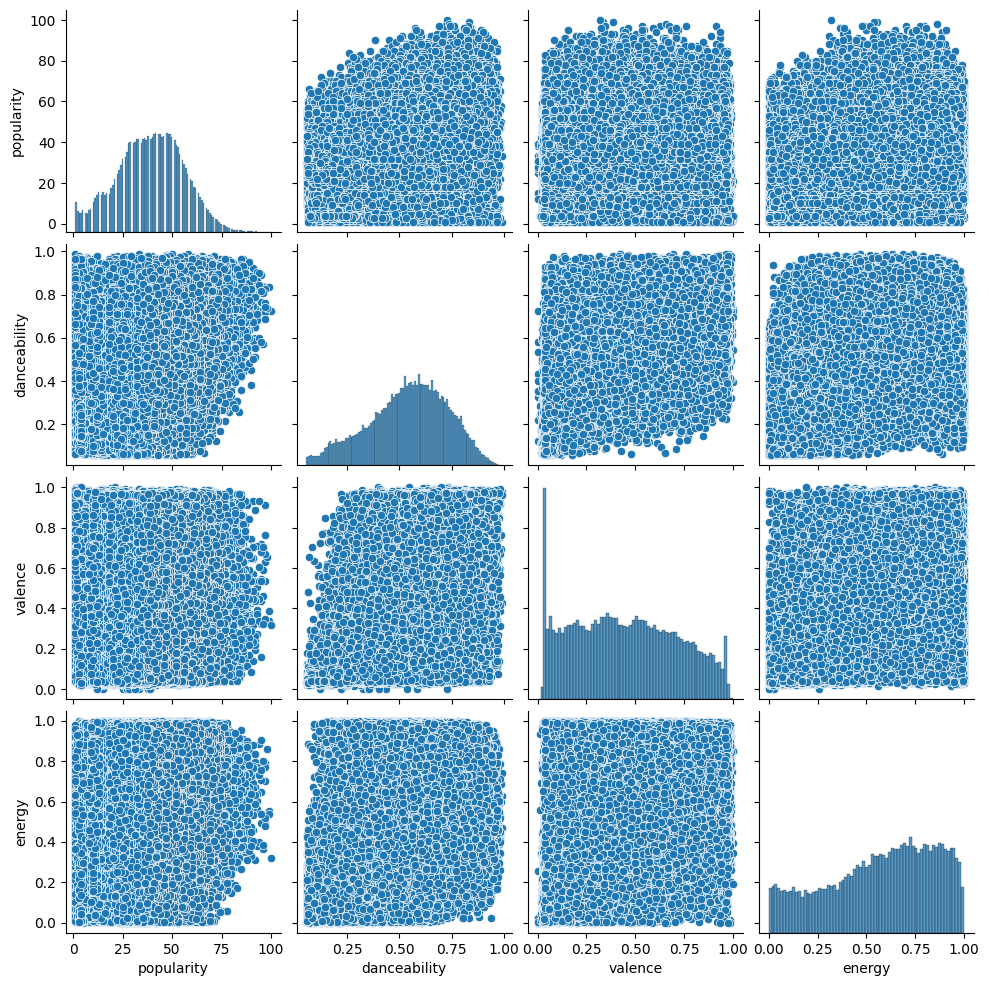

In [ ]:
sb.pairplot(data = dataset)

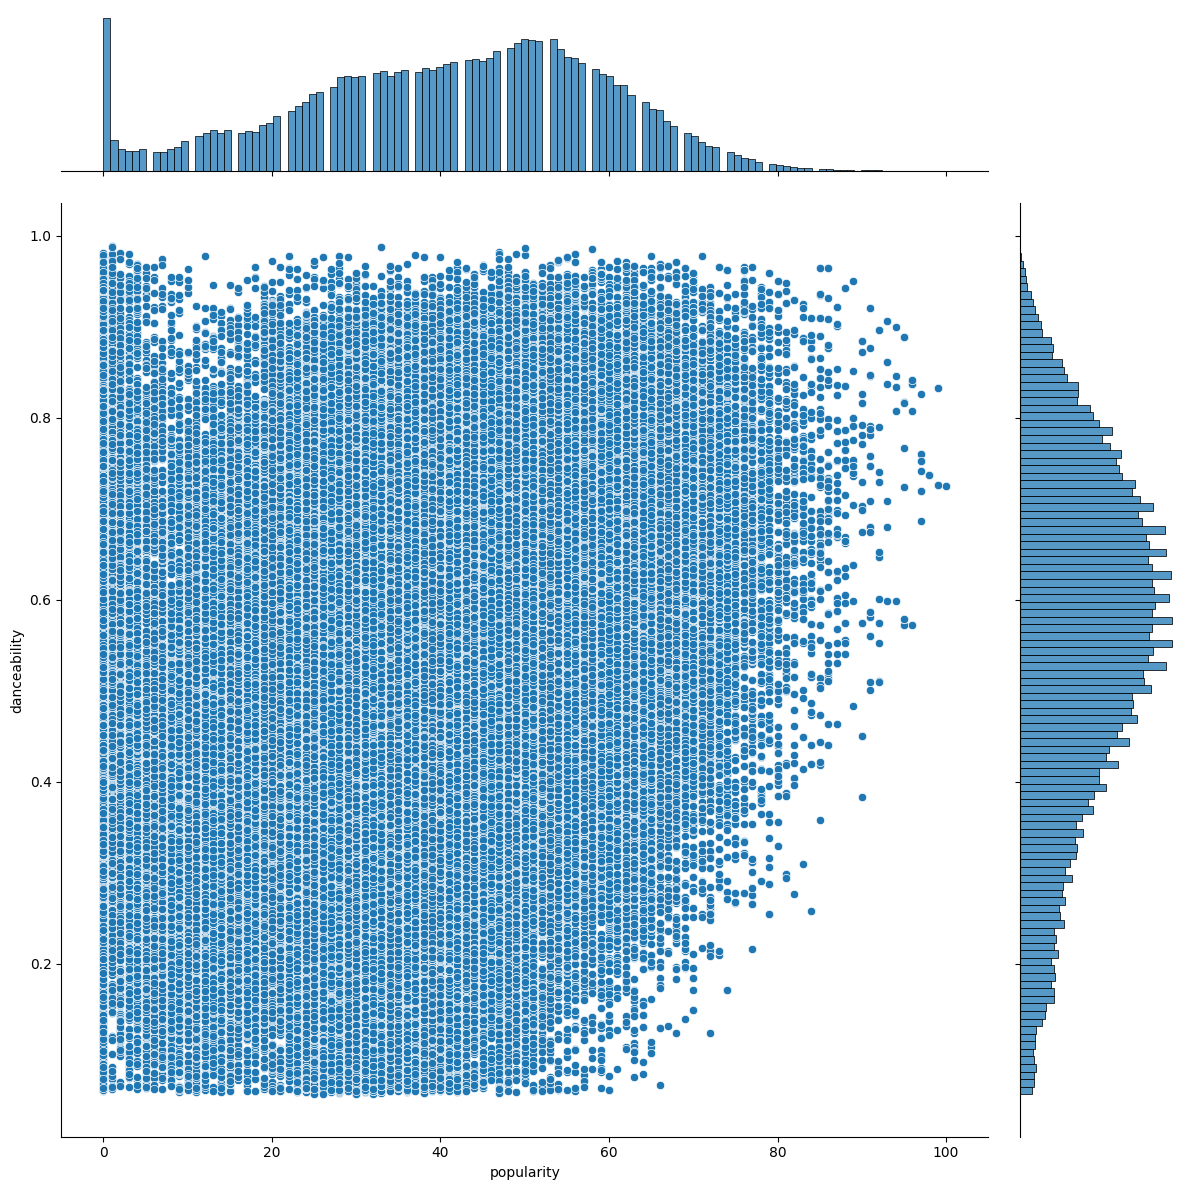

In [ ]:
jointDF1 = pd.concat([popularity, danceability], axis = 1).reindex(popularity.index)
sb.jointplot(data = jointDF1, x = "popularity", y = "danceability", height = 12)

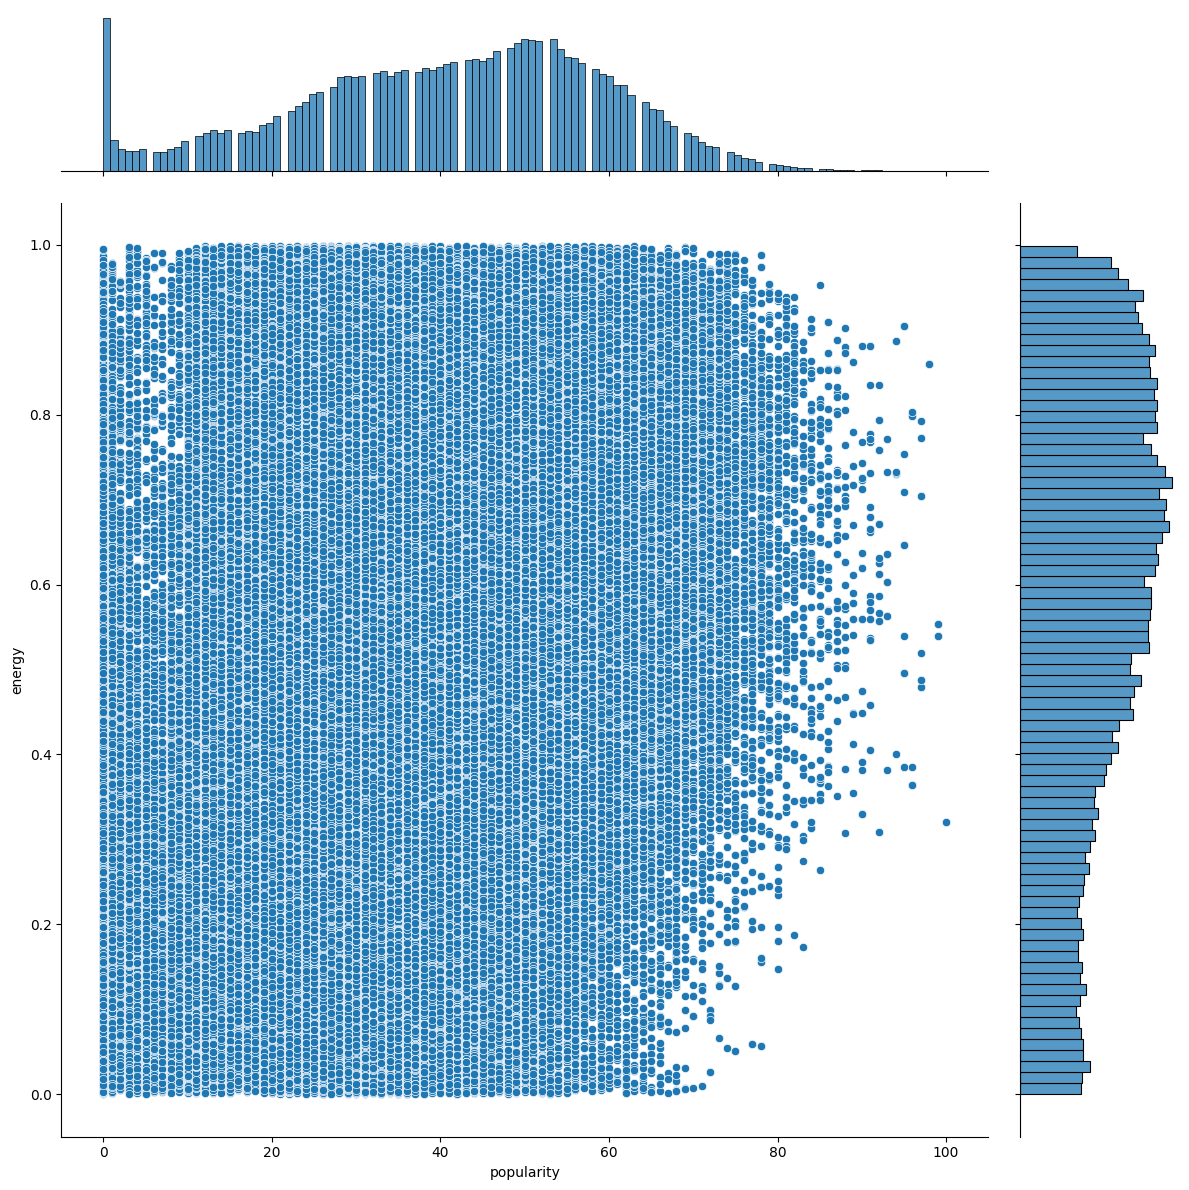

In [ ]:
jointDF2 = pd.concat([popularity, energy], axis = 1).reindex(popularity.index)
sb.jointplot(data = jointDF2, x = "popularity", y = "energy", height = 12)

In [ ]:
genre = dataset['genre']
genre.value_counts()

,count
genre,
Comedy,9681
Soundtrack,9646
Indie,9543
Jazz,9441
Pop,9386
Electronic,9377
Children’s Music,9353
Folk,9299
Hip-Hop,9295
